In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

# Make Input

In [5]:
def txtToDataframe(filename, flag1, flag2):
    file = open(filename, 'r')
    lines = file.readlines()
    datas = []
    for line in lines:
        txt = line.replace('   ', ' ').lstrip().rstrip().replace(' ', ',')
        data = txt.split(',')
        datas.append(data)
    df = pd.DataFrame(datas)
    df.columns = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'F8', 'AF4']
    df['label1']=flag1
    df['label2']=flag2
    return df


def getData(src) :
    file_list = os.listdir(src)
    
    rating = pd.DataFrame(pd.read_csv(src+'ratings.txt'))
    file_list.remove('ratings.txt')
    
    dataList=[]
    highList=[]
    lowList=[]
    
    print(rating.columns)
    j=0
    for i in rating['subject']:
        if i<10:
            num = str(0)+str(i)
        else:
            num = str(i)
        dataList.append(txtToDataframe(src+'sub'+num+'_hi.txt', 1,rating['test'][j]))
        dataList.append(txtToDataframe(src+'sub'+num+'_lo.txt', 0,rating['rest'][j]))
        highList.append(txtToDataframe(src+'sub'+num+'_hi.txt', 1,rating['test'][j]))
        lowList.append(txtToDataframe(src+'sub'+num+'_lo.txt', 0,rating['rest'][j]))
        j+=1
    return dataList, highList, lowList

src = 'data/STEW Dataset/'
originalData, highData, lowData = getData(src)

Index(['subject', 'rest', 'test'], dtype='object')


In [6]:
mergedData = pd.concat([originalData[0],originalData[1]],ignore_index=True)
for i in range(2,len(originalData)):
    mergedData = pd.concat([mergedData,originalData[i]],ignore_index=True)
mergedData = mergedData.apply(pd.to_numeric)
mergedData

,AF3,F7,F3,FC5,T7,O1,O2,P8,T8,FC6,F4,F8,F8,AF4,label1,label2
0,4584.62,3902.05,4571.79,4589.23,4124.62,3825.13,4152.82,4579.49,4690.77,4260.00,4027.18,4385.13,4480.51,4230.77,1,8
1,4584.10,3895.90,4574.87,4567.69,4124.10,3827.18,4157.95,4585.13,4695.38,4268.21,4034.36,4380.00,4501.54,4197.44,1,8
2,4574.36,3893.85,4576.92,4572.82,4123.59,3829.23,4165.13,4590.26,4702.56,4281.54,4030.77,4366.67,4521.03,4176.41,1,8
3,4573.85,3906.15,4572.82,4612.31,4137.95,3830.77,4167.18,4596.92,4706.15,4285.64,4038.46,4376.41,4518.97,4207.18,1,8
4,4583.59,3911.28,4570.26,4621.03,4150.77,3833.85,4166.15,4597.44,4705.13,4282.05,4051.79,4387.18,4520.51,4220.00,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1727995,4168.21,4124.62,4123.08,4181.54,4621.03,4051.79,4295.38,4333.85,4434.87,4038.97,4557.44,4714.87,4711.79,4698.46,0,1
1727996,4166.15,4123.08,4124.10,4180.51,4625.13,4053.85,4294.87,4326.15,4429.23,4035.90,4556.92,4716.92,4706.67,4693.85,0,1
1727997,4167.69,4120.51,4122.05,4178.97,4622.05,4051.79,4289.74,4311.28,4420.00,4024.62,4553.33,4712.82,4699.49,4688.72,0,1
1727998,4170.26,4120.00,4121.54,4181.03,4616.92,4050.77,4288.21,4312.31,4421.54,4024.10,4553.85,4712.31,4703.08,4693.85,0,1


In [7]:
label=mergedData['label1']
label2=mergedData['label2']
data=mergedData.drop(['label1','label2'],axis=1)

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)
data = pd.DataFrame(scaled, columns = data.columns, index=data.index)
data

,AF3,F7,F3,FC5,T7,O1,O2,P8,T8,FC6,F4,F8,F8,AF4
0,0.558932,0.452258,0.539627,0.553295,0.479273,0.449631,0.482450,0.542340,0.558323,0.505813,0.479338,0.521798,0.533296,0.494656
1,0.558867,0.451482,0.540022,0.550698,0.479207,0.449895,0.483076,0.543015,0.558871,0.506793,0.480193,0.521187,0.535799,0.490618
2,0.557644,0.451223,0.540286,0.551317,0.479142,0.450158,0.483952,0.543629,0.559726,0.508383,0.479766,0.519600,0.538119,0.488070
3,0.557580,0.452775,0.539759,0.556078,0.480956,0.450357,0.484202,0.544427,0.560153,0.508873,0.480681,0.520759,0.537874,0.491798
4,0.558803,0.453422,0.539430,0.557129,0.482576,0.450753,0.484076,0.544489,0.560032,0.508444,0.482268,0.522042,0.538057,0.493351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1727995,0.506663,0.480335,0.481982,0.504143,0.541975,0.478809,0.499843,0.512926,0.527864,0.479439,0.542453,0.561057,0.560825,0.551323
1727996,0.506404,0.480140,0.482113,0.504018,0.542493,0.479074,0.499781,0.512004,0.527193,0.479073,0.542391,0.561301,0.560215,0.550765
1727997,0.506598,0.479816,0.481850,0.503833,0.542104,0.478809,0.499155,0.510224,0.526094,0.477727,0.541964,0.560813,0.559361,0.550143
1727998,0.506920,0.479752,0.481785,0.504081,0.541456,0.478677,0.498968,0.510347,0.526277,0.477665,0.542026,0.560752,0.559788,0.550765


In [145]:
def windowing_dataset(data, label, window_size):
    data_list = []
    label_list = []
    
    for i in range(0,len(data)//window_size,window_size):
        data_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i]))
    return np.array(data_list), np.array(label_list)

dataList, labelList = windowing_dataset(data,label,10)
#labelList = to_categorical(labelList,9)
dataList = np.expand_dims(dataList, axis=-1)
print(data.shape, label.shape, dataList.shape, labelList.shape)

(1728000, 14) (1728000,) (17280, 10, 14, 1) (17280,)


In [146]:
X_train, X_, y_train, y_ = train_test_split(dataList,labelList, train_size=0.7, random_state=True ,stratify = labelList)
X_valid, X_test, y_valid, y_test = train_test_split(X_,y_, train_size=0.5, random_state=True ,stratify = y_)

print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)
print(X_train.dtype, X_valid.dtype, X_test.dtype, y_train.dtype, y_valid.dtype, y_test.dtype)

(12096, 10, 14, 1) (2592, 10, 14, 1) (2592, 10, 14, 1) (12096,) (2592,) (2592,)
float64 float64 float64 int64 int64 int64


# Model Tuning

## Model 1

In [153]:
from autokeras.keras_layers import ExpandLastDim
from autokeras.keras_layers import CastToFloat32
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [149]:
import matplotlib.pyplot as plt

def drawResult(history):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper left')

    plt.show()

In [156]:
def Model1_1():
    model = Sequential()
    model.add(InputLayer(input_shape=(10, 14)))
    model.add(ExpandLastDim())
    model.add(CastToFloat32())
    model.add(Conv2D(256, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    model.add(Conv2D(256, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D(2,2))
    model.add(GlobalMaxPooling2D())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
expand_last_dim_10 (ExpandLa (None, 10, 14, 1)         0         
_________________________________________________________________
cast_to_float32_2 (CastToFlo (None, 10, 14, 1)         0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 8, 12, 256)        2560      
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 6, 10, 256)        590080    
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 3, 5, 256)         0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 3, 5, 32)          73760     
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 3, 5, 32)        

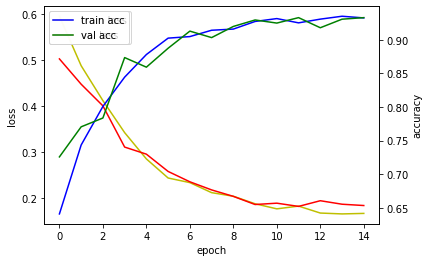

In [158]:
from sklearn.metrics import f1_score

def runModel(model, crossentropy):
    early_stop = EarlyStopping(monitor='val_loss', patience=3)
    model.compile(optimizer='adam', loss= crossentropy, metrics='accuracy')

    history = model.fit(X_train, y_train, 
                        epochs = 200, 
                        validation_data = (X_valid, y_valid), 
                        callbacks=[early_stop], verbose=2)
    eval_model(model)
    drawResult(history)
    return
    
def eval_model(model):
    y_pred = model.predict(X_test)
    y_pred=predictions.round(0).astype('int32')

    f1_score(y_test, y_pred, average='macro')
    print(f1_score)
    return
    
runModel(Model1_1(),'binary_crossentropy') #binary_crossentropy, #sparse_categorical_crossentropy, categorical_crossentropy

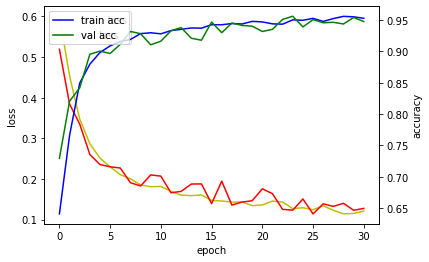

0.9362845393988135